## Prompts Exploratory Data Analysis
Using this notebook, we can analyze and extract key insights from the prompts used for training our LLM model.

#### EDA Overview
Token Wise:
- Average Tokens Length
- Token Lengths Distribution
- Min/Max in tokens

Coverage:
- Prompt Coverage as a function of Tokens Lenght
- Prompt Coverage as a function of hardcoded LLM context size.

Word Analysis:
- Word Cloud
---

### Insights:
- `Average Tokens Length` : see wether our prompts are balanced in relation to model context size.
- `Token Lengths Distribution` : see variety of sentence lengths, skewed towards short or long sentences
- `Min/Max in tokens` : anomalies or outliers in the training set

- `Prompt Coverage w.r.t Tokens Lenght` : how effective the prompts cover the entire range of tokens lengths
- `Word Cloud` : main topics and subjects within the dataset

In [1]:
import pandas as pd

# Specify the path to your Parquet file
parquet_file_path = 'train.parquet'

# Read the Parquet file into a DataFrame
df = pd.read_parquet(parquet_file_path)
df.head()
print(len(df))

3193


In [8]:
df.head()
df.iloc[1]['input']



"I'm a medium height woman with a soft, round figure. I love bohemian styles with flowing dresses and skirts that embrace my curves."

In [6]:
df.iloc[1]['completion']

'Outfit 1:\n- Top: A loose, flowy peasant blouse in a vibrant floral print.\n- Bottom: A high-waisted maxi skirt in a soft, lightweight fabric with a bohemian print.\n- Shoes: Brown leather sandals with intricate braided details.\n- Accessories: Layered beaded necklaces, a floppy straw hat, and a woven rattan bag.\n\nOutfit 2:\n- Top: A relaxed, off-the-shoulder chambray blouse with billowy sleeves.\n- Bottom: A midi skirt in a earthy tone, such as olive green, adorned with delicate lace trim.\n- Shoes: Leather ankle boots with fringe details.\n- Accessories: A wide brimmed fedora hat, a long pendant necklace, and a crossbody bag in a neutral color.\n\nOutfit 3:\n- Top: A flowy, bohemian-inspired peasant top with bell sleeves and embroidered details.\n- Bottom: A pair of wide-legged, high-waisted palazzo pants in a bold, tribal print.\n- Shoes: Strappy leather sandals with metallic accents.\n- Accessories: Layered bangles, oversized sunglasses, and a fringe crossbody bag.\n\nOutfit 4:\

In [7]:
df.iloc[1]['context']

"I'm going to a nature retreat."

In [7]:
df.head()

,input,completion,context
0,"I'm a tall, athletic man with broad shoulders ...",Outfit Combination 1:\n- Top: Fitted white lin...,I'm going to a nature retreat.
1,"I'm a medium height woman with a soft, round f...","Outfit 1:\n- Top: A loose, flowy peasant blous...",I'm going to a nature retreat.
2,"I'm a petite, slender man with a youthful appe...",Outfit Combination 1:\n\nTop: A light-colored ...,I'm going to a nature retreat.
3,"I'm a plus-size woman with a pear shape, carry...","Outfit 1:\n- Top: A flowy, printed tunic in ea...",I'm going to a nature retreat.
4,"I'm a short, curvy man with a muscular build. ...","Outfit 1:\n- Top: A loose, lightweight button-...",I'm going to a nature retreat.


In [9]:
# # Setup Dependencies
# ! pip install seaborn matplotlib datasets transformers wordcloud


In [8]:
# Load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
# tokenizer.eos_token = "EOS"
tokenizer.pad_token = tokenizer.eos_token
print(f"Loaded Tokenizer : {tokenizer}" if tokenizer else "Failed to load")

/Users/gowthamkrishnaaddluri/opt/anaconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|███████████████████████████████████████████████████████████████████████████████████| 967/967 [00:00<00:00, 118kB/s]
tokenizer.model: 100%|██████████████████████████████████████████████████████████████████████████████████████| 493k/493k [00:00<00:00, 5.65MB/s]
tokenizer.json: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1.80M/1.80M [00:00<00:00, 3.64MB/s]
special_tokens_map.json: 100%|██████████████████████████████████████████████████████████████████████████████| 72.0/72.0 [00:00<00:00, 76.9kB/s]

Loaded Tokenizer : LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [21]:
# Prepare training data parser
from enum import Enum
from pathlib import Path
from datasets import load_dataset
from dataclasses import dataclass, field

class Scope(Enum):
    TRAIN = "train"

@dataclass
class DataSample:
    input: str = field(repr=False)
    context: str = ""
    completion: str = ""
    
    def formatted(self):
        """Train containing raw text fields"""
        template = """
        {input}
        {context}
        {completion}
        """
        complete = template.format(input=self.input, context=self.context, completion=self.completion)
        return complete

class DatasetGenerator:
    def __init__(self, dataset_file_path: Path, scope: Scope):
        self._scope = scope
        self.tokenizer = tokenizer
        self.dataset = self._load_dataset(dataset_file_path)
    
    @property
    def size(self):
        return len(self.dataset[self._scope.value])
    
    def _load_dataset(self, dataset_file_path: Path):
        try:
            dataset = load_dataset("parquet", data_files=str(dataset_file_path))
            #dataset = load_dataset(dataset_file_path)
            print("=" * 10 + " Info " + "=" * 10)
            print(f"Dataset Path : {dataset_file_path}")
            print(f"Loaded : {len(dataset[self._scope.value])} samples.")
            return dataset
        except FileNotFoundError:
            print("JSON file not found.")
            raise FileNotFoundError("Check the file path")
        except SyntaxError:
            print("JSON file badly formatted.")
            raise FileNotFoundError("Forgot how to write json")

    def tokenized_samples(self, tokenizer):
        """Iterates through the dataset prompts, tokenizes and saves a stores a sublist
        of tokens for each prompt."""
        formatted_samples = list(map(lambda en: DataSample(**en), self.dataset[self._scope.value]))
        tokenized_samples = []
        for sample in formatted_samples:
            as_str = sample.formatted()
            tokenized = tokenizer(as_str)
            tokenized = tokenized["input_ids"]
            tokenized_samples.append(tokenized)
        return tokenized_samples
            
    def samples_gen(self):
        formatted_samples = list(map(lambda en: DataSample(**en), self.dataset[self._scope.value]))
        for sample in formatted_samples:
            yield sample


In [32]:

# 1. Prerequisites
DATASET_ROOT = Path("/Users/gowthamkrishnaaddluri/Documents/courses/mistral_qlora/instruct-finetune-mistral")
dataset_json_file = DATASET_ROOT / "train.parquet"

# path_data = '/Users/gowthamkrishnaaddluri/Documents/courses/mistral_qlora/instruct-finetune-mistral/train.parquet'
# 2. Prepare dataset
dataset = DatasetGenerator(dataset_file_path=dataset_json_file, scope=Scope.TRAIN)
tokenized_samples = dataset.tokenized_samples(tokenizer)

========== Info ==========
Dataset Path : /Users/gowthamkrishnaaddluri/Documents/courses/mistral_qlora/instruct-finetune-mistral/train.parquet
Loaded : 3193 samples.


In [33]:
# Replace 'your-model-name' with the actual model name
model_name = 'mistralai/Mistral-7B-v0.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenized samples (list of lists of integers)
tokenized_samples_example = tokenized_samples[3]

# Decode tokenized samples to English
decoded_samples = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in tokenized_samples]

# Display the decoded samples
for i, decoded_sample in enumerate(decoded_samples):
    print(f"Sample {i + 1}: {decoded_sample}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
len(tokenized_samples[3])

629

In [29]:
df.iloc[3]

input         I'm a plus-size woman with a pear shape, carry...
completion    Outfit 1:\n- Top: A flowy, printed tunic in ea...
context                          I'm going to a nature retreat.
Name: 3, dtype: object

In [44]:
tokenizer

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### EDA-01 Tokens Based
- Average Tokens Length
  - Check the average length in tokens of your fine-tuning prompts. Helps to identify the overall context-window you can aim for.
- Token Lengths Distribution
  - Visually inspect which context-window size covers all your fine-tuning dataset.
- Min/Max Token Distributions + (25-75) Percentiles
  - Verbose representation of tokens lengths of your fine-tuning dataset.

In [34]:
# Average Tokens Length
import numpy as np
toks_mean = np.mean([len(x) for x in tokenized_samples])
print(f"Average Prompt Lenght : {toks_mean:.0f} tokens")


Average Prompt Lenght : 625 tokens


Using arbitrary: MinTokenLimit = 270 toks.
Using arbitrary: MaxTokenLimit = 1200 toks


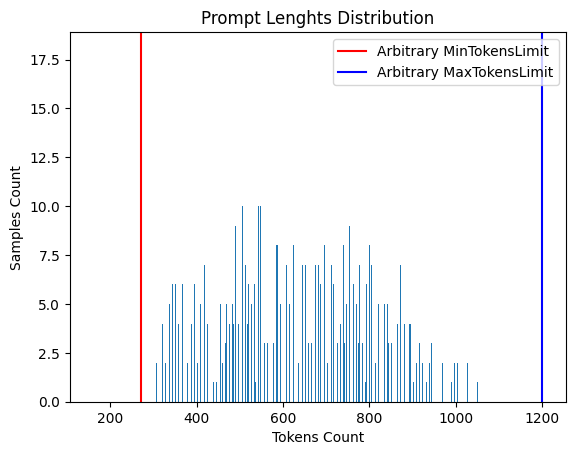

In [37]:
# Token Lengths Distribution
import matplotlib.pyplot as plt

lens = [len(x) for x in tokenized_samples]
min_toks_bar = 270
max_toks_bar = 1200
plt.hist(lens, bins=len(tokenized_samples))
plt.title("Prompt Lenghts Distribution")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
print(f"Using arbitrary: MinTokenLimit = {min_toks_bar} toks.")
print(f"Using arbitrary: MaxTokenLimit = {max_toks_bar} toks")
plt.axvline(min_toks_bar, color="red", label="Arbitrary MinTokensLimit")
plt.axvline(max_toks_bar, color="blue", label="Arbitrary MaxTokensLimit")
plt.legend()
plt.show()


In [38]:
# Percentiles .25 .5 .75
import numpy as np
lens = [len(x) for x in tokenized_samples]
print(f"Minimum Prompt Lenght : {np.min(lens)} tokens")
print(f"Maximum Prompt Lenght : {np.max(lens)} tokens")

p25, p50, p75 = np.percentile(lens, [25, 50, 75])
print(f"25th percentile: {p25:.0f} tokens")
print(f"50th (median) percentile: {p50:.0f} tokens")
print(f"75th percentile: {p75:.0f} tokens")

Minimum Prompt Lenght : 159 tokens
Maximum Prompt Lenght : 1203 tokens
25th percentile: 498 tokens
50th (median) percentile: 613 tokens
75th percentile: 754 tokens


### EDA-02 Prompt Coverage Based
- Prompt Coverage as a function of Tokens Length
  - Establishing a context-window size, inspect the prompts tokens distribution of the dataset that fits within the selected window.

Min selected ctx-window: 250 toks
Max selected ctx-window: 1056 toks


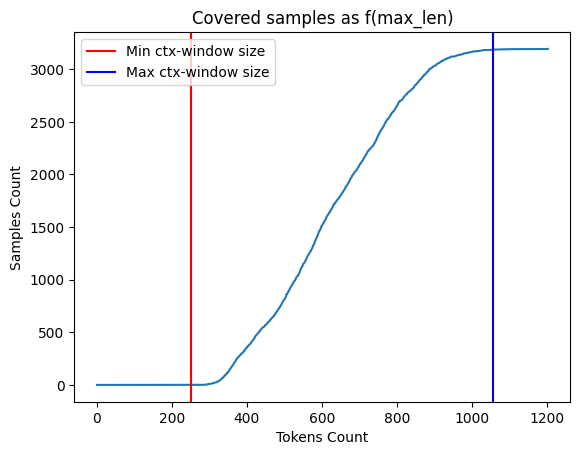

In [40]:
# Plot tokens distributions
plt.plot([len([l for l in lens if l <= m]) for m in range(max(lens) + 1)])
context_window_p1 = 250
context_window_p2 = 1056
print(f"Min selected ctx-window: {context_window_p1} toks")
print(f"Max selected ctx-window: {context_window_p2} toks")
plt.title("Covered samples as f(max_len)")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
plt.axvline(x=context_window_p1, color="red", label="Min ctx-window size")
plt.axvline(x=context_window_p2, color="blue", label="Max ctx-window size")
plt.legend()
plt.show()

### EDA-03 Prompt lengths boxplot
- Median: This line shows the median value of token lengths in each interval. Inspect the central tendency.
- Box Length: A larger box suggests greater variability in prompt lengths within that interval.
- Out-bound lines: They represent the range of the data.
- Points outside the whiskers are outliers. Unusually long/short compared to the existing values within that interval.

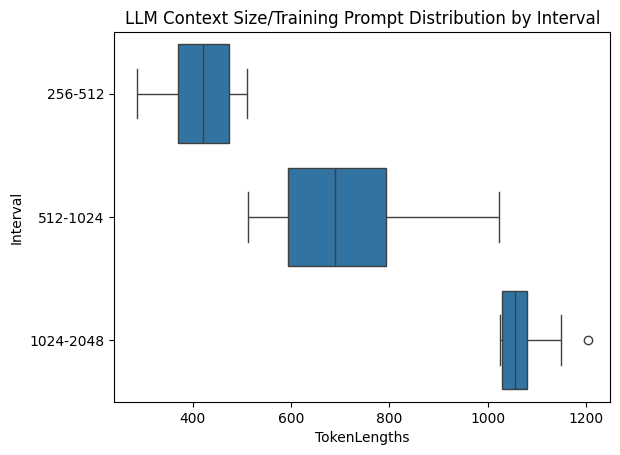

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


intervals = [(256, 512), (512, 1024), (1024, 2048)]

data = []
for length in lens:
    for start, end in intervals:
        if start <= length < end:
            data.append({'TokenLengths': length, 'Interval': f'{start}-{end}'})
            break

df = pd.DataFrame(data)

sns.boxplot(x='TokenLengths', y='Interval', data=df)
plt.title('LLM Context Size/Training Prompt Distribution by Interval')
plt.show()


### EDA-04 WordCloud Analysis
- Visual representation of most representative words
- Helps in preventing bias towards a specific theme (overfit)
- Helps into processing/removing irrelevant frequent words
- Could serve as a basic quality check of your overall dataset vocabulary

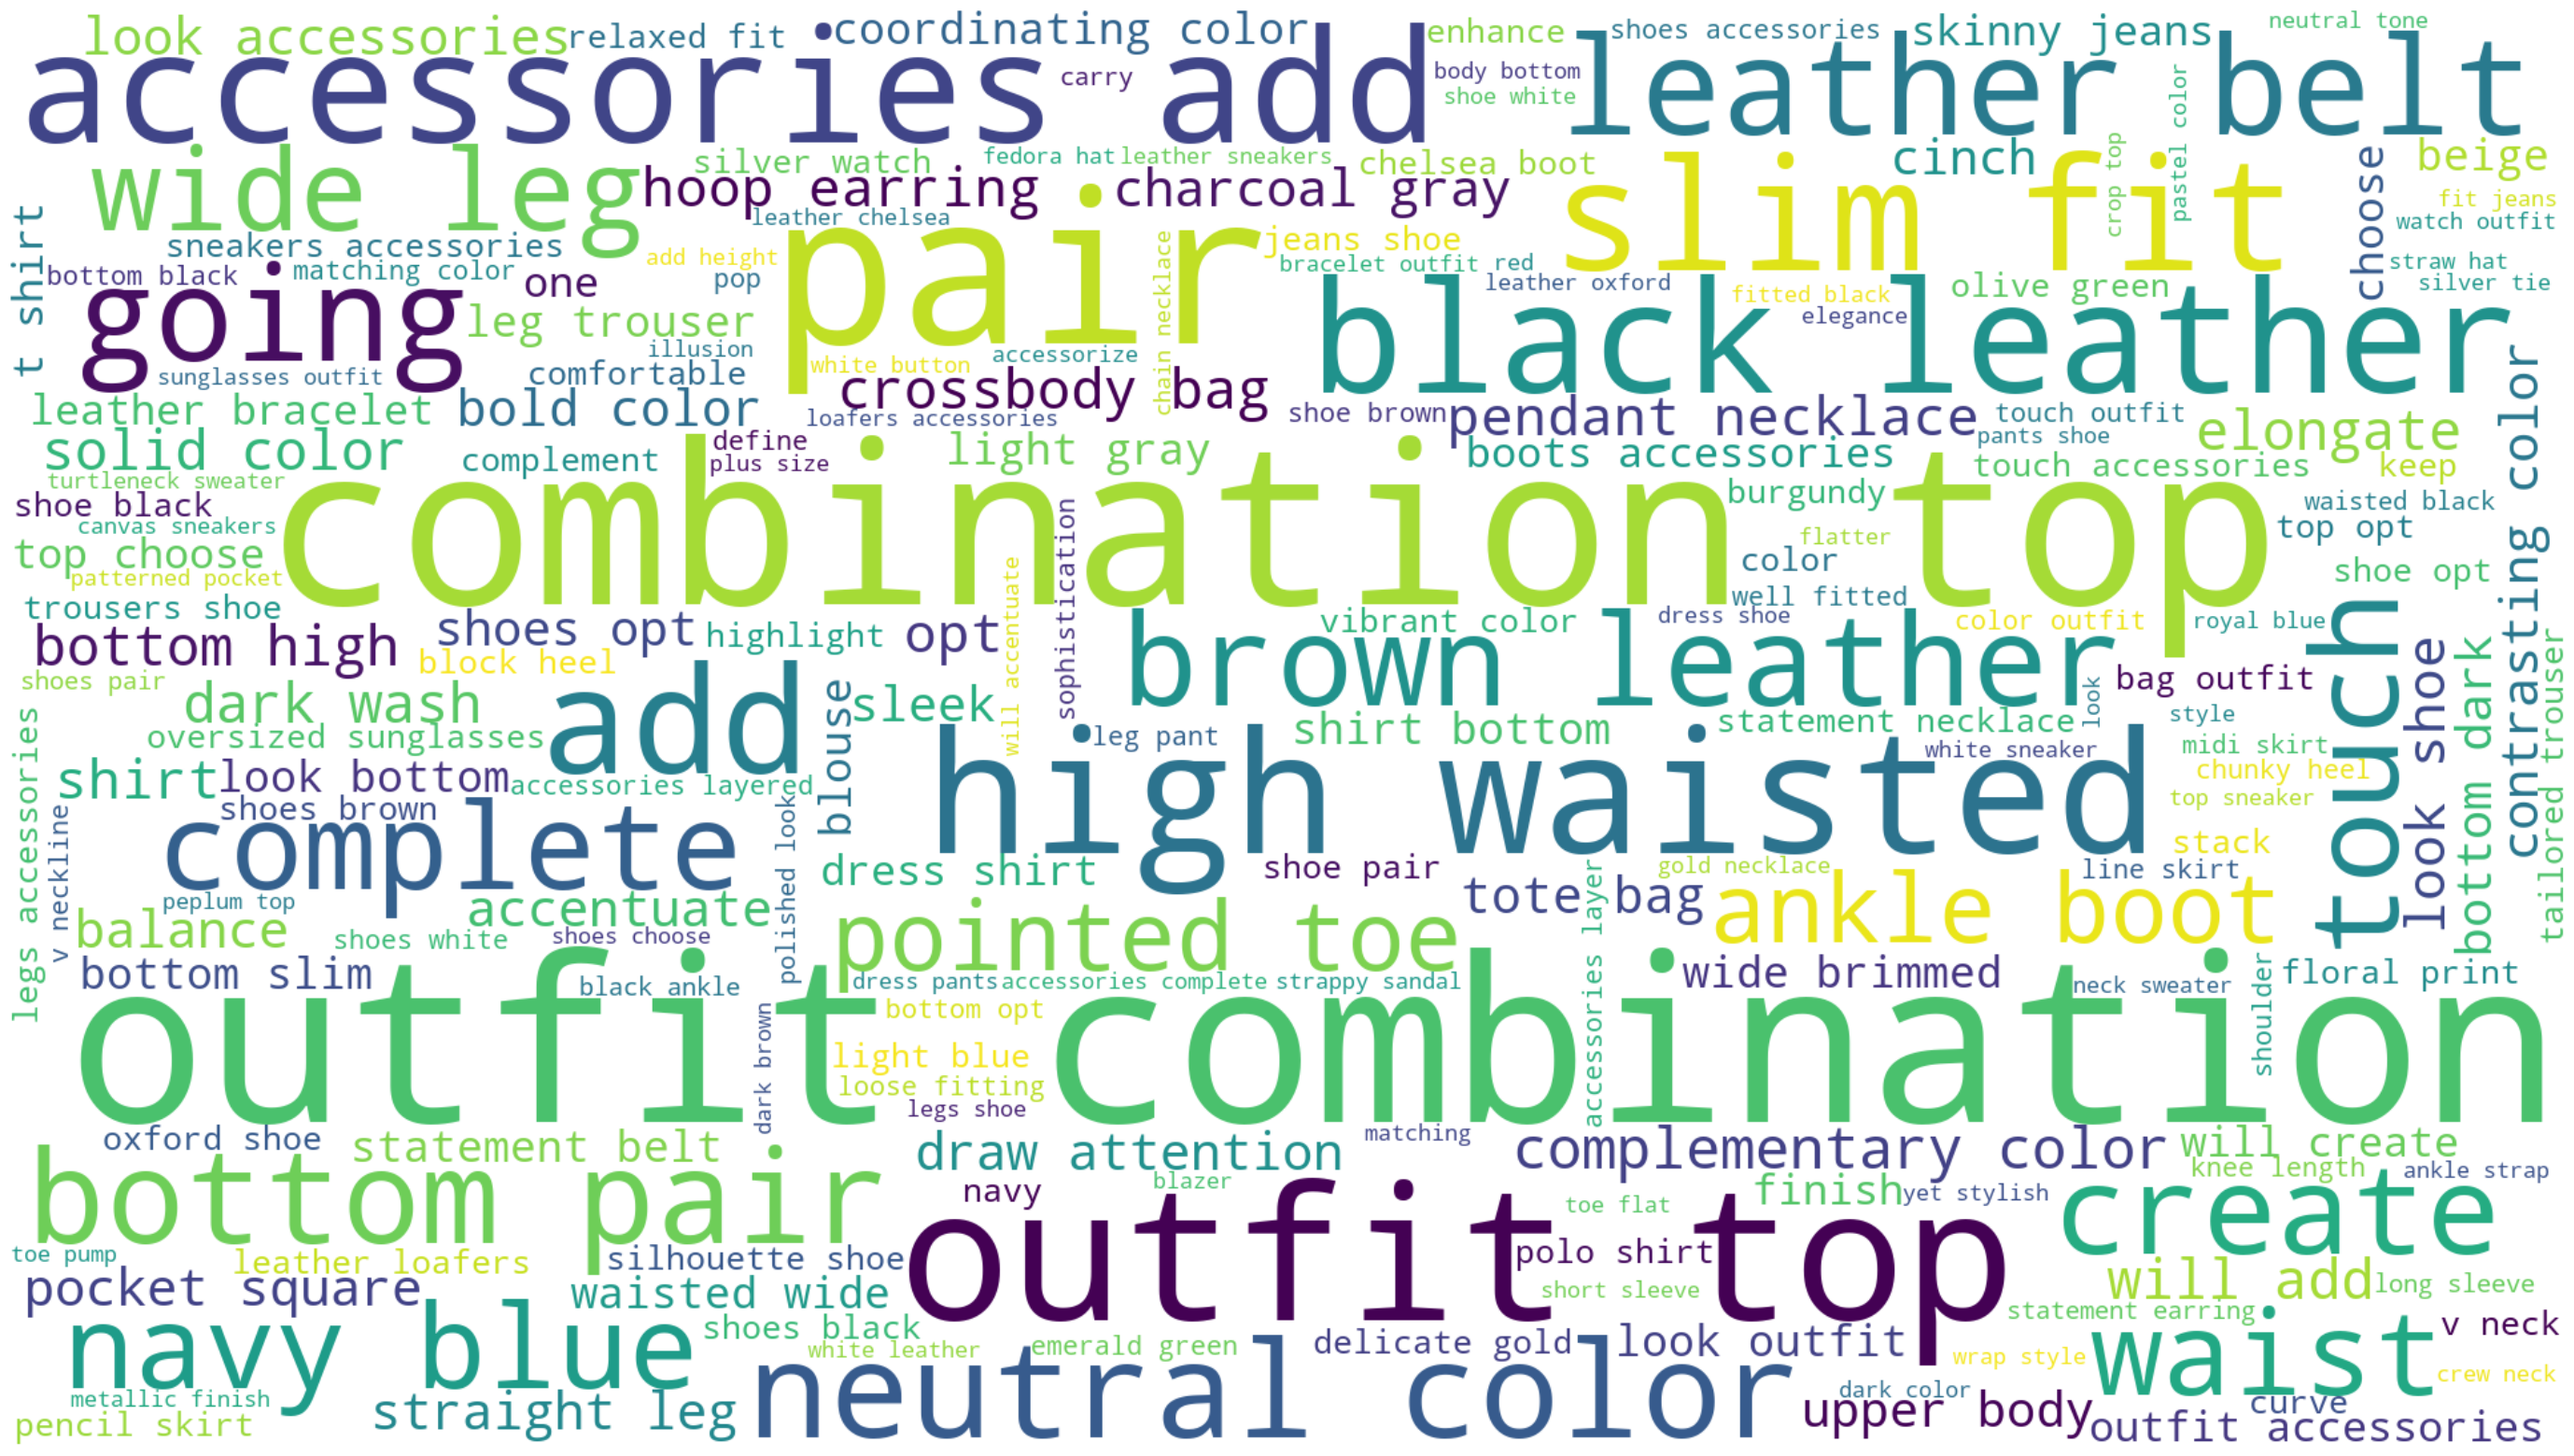

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
generator = dataset.samples_gen()
for sample in generator:
    text += sample.formatted()
text = text.lower().replace('.', '').replace(',', '')

wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text)

plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
